# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [3]:
# Imports 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import zipfile
import os
from urllib.request import urlretrieve
import cv2
import sklearn.model_selection

%matplotlib inline

## Step 0: Dataset Download
Download link: https://d17h27t6h515a5.cloudfront.net/topher/2016/October/5811165e_traffic-signs-data.zip/traffic-signs-data.zip.zip

Rename train.p and test.p to train.pickle and test.pickle, respectively

In [4]:
def download(url, file):
    """
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    """
    print('Downloading ' + file + '...')
    if not os.path.isfile(file):
        urlretrieve(url, file)
        print('Download Finished')
    else:
        print('File already in the filesystem!')

download('https://d17h27t6h515a5.cloudfront.net/topher/2016/October/5811165e_traffic-signs-data.zip/traffic-signs-data.zip.zip', 'traffic-signs-data.zip.zip')


File already in the filesystem!


In [5]:
train_filename = 'train.pickle'
test_filename = 'test.pickle'

if not os.path.isfile(train_filename) or not os.path.isfile(test_filename):
    # Unzip
    print('Unzipping file...')
    with zipfile.ZipFile("traffic-signs-data.zip.zip","r") as zip_ref:
        zip_ref.extractall()

    # Rename    
    print('Renaming pickle files...')
    os.rename('train.p', 'train.pickle')
    os.rename('test.p', 'test.pickle')
    print('Done')
else:
    print('Pickle files already in the filesystem!')


Pickle files already in the filesystem!


---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [6]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.pickle'
testing_file = 'test.pickle'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [7]:
### To start off let's do a basic data summary.
# TODO: number of training examples
n_train = len(y_train)

# TODO: number of testing examples
n_test = len(y_test)

# TODO: what's the shape of an image?
image_shape = X_train.shape[1:3]

# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


In [8]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

In [9]:
# Shapes of the input arrays
print("X_train.shape = ", X_train.shape)
print("y_train.shape = ", y_train.shape)
print("X_test.shape = ", X_test.shape)
print("y_test.shape = ", y_test.shape)

X_train.shape =  (39209, 32, 32, 3)
y_train.shape =  (39209,)
X_test.shape =  (12630, 32, 32, 3)
y_test.shape =  (12630,)


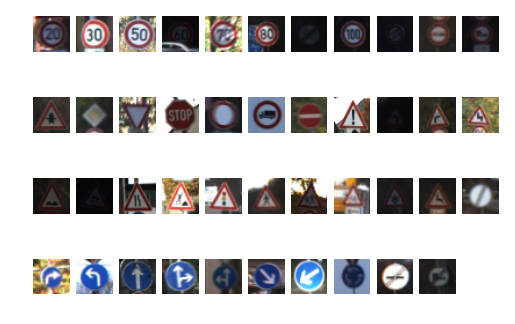

In [10]:
# Plot one example of the 43 different classes
_, idx = np.unique(y_test, return_index=True)
X_test_unique = X_test[idx, :, :, :]
for i in range(0, len(idx)):
    plt.subplot(4, 11, i+1)
    plt.imshow(X_test_unique[i, :, :, :]);
    plt.axis('off')

In [11]:
# Print the labels
labels_text = []
with open('signnames.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in reader:
        print(', '.join(row))        
        if i > 0:
            labels_text.append(row[1])        
        i = i + 1

ClassId, SignName
0, Speed limit (20km/h)
1, Speed limit (30km/h)
2, Speed limit (50km/h)
3, Speed limit (60km/h)
4, Speed limit (70km/h)
5, Speed limit (80km/h)
6, End of speed limit (80km/h)
7, Speed limit (100km/h)
8, Speed limit (120km/h)
9, No passing
10, No passing for vechiles over 3.5 metric tons
11, Right-of-way at the next intersection
12, Priority road
13, Yield
14, Stop
15, No vechiles
16, Vechiles over 3.5 metric tons prohibited
17, No entry
18, General caution
19, Dangerous curve to the left
20, Dangerous curve to the right
21, Double curve
22, Bumpy road
23, Slippery road
24, Road narrows on the right
25, Road work
26, Traffic signals
27, Pedestrians
28, Children crossing
29, Bicycles crossing
30, Beware of ice/snow
31, Wild animals crossing
32, End of all speed and passing limits
33, Turn right ahead
34, Turn left ahead
35, Ahead only
36, Go straight or right
37, Go straight or left
38, Keep right
39, Keep left
40, Roundabout mandatory
41, End of no passing
42, End of n

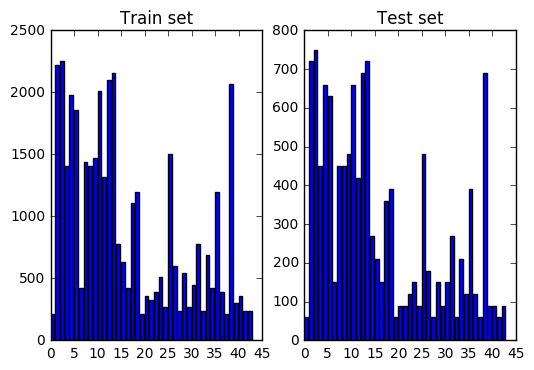

In [12]:
# Display the number of examples for each class, for training and test set
labels = np.array(range(0, n_classes))
train_n_examples = np.zeros(n_classes, dtype=np.int32)
test_n_examples = np.zeros(n_classes, dtype=np.int32)
for i in labels:
    # Get indices in Y that correspond to 'i', for train and test sets
    train_n_examples[i] = sum(y_train == i)
    test_n_examples[i] = sum(y_test == i)

# Plot in a bar diagram
plt.subplot(1,2,1)
plt.bar(labels, train_n_examples);
plt.title('Train set');
plt.subplot(1,2,2)
plt.bar(labels, test_n_examples);    
plt.title('Test set');

We can observe that the training data is **not equally distributed** among the different classes. This indicates that the algorithm will be more fine-tuned for those classes for which there are more examples. If we want to improve the network's ability to generalize, we should have roughly the same number of examples for each class. This could be accomplished by generating synthetic data.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [13]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

In [14]:
### RGB to grayscale conversion. According to the paper, it gives better results
def rgb_to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

### Normalization: zero mean and unit variance
def normalization(x):
    a = 0.1
    b = 0.9
    x_min = 0
    x_max = 255
    
    return a + (x - x_min) * (b - a) / (x_max - x_min)

def preprocess_set(dataset):
    # Declare output array
    shape = [x for x in dataset.shape]
    shape[3] = 1 # Will convert to grayscale
    dataset_preprocessed = np.zeros(shape)
    
    # Convert from RGB to grayscale
    for i in range(0, dataset.shape[0]):
        dataset_preprocessed[i, :, :, :] = np.expand_dims(rgb_to_grayscale(dataset[i, :, :]), axis=2)
    
    #dataset_preprocessed = dataset
        
    # Perform normalization
    dataset_preprocessed = normalization(dataset_preprocessed)
    
    return dataset_preprocessed

def one_hot_encoding(y_data, depth):
    return np.eye(depth)[y_data]

In [15]:
print('Preprocessing train and test datasets...')
X_train_preprocessed = preprocess_set(X_train)
X_test_preprocessed = preprocess_set(X_test)

y_train_preprocessed = one_hot_encoding(y_train, depth = n_classes)
y_test_preprocessed = one_hot_encoding(y_test, depth = n_classes)
print('Done')

Preprocessing train and test datasets...
Done


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

The following techniques have been used to preprocess the data:

-**RGB to grayscale conversion**. According to the paper, this results in a slightly better performance. In addition, this will make our network easier to train, since the input is a 32x32 image instead of 32x32x3

-**Normalization**. The goal is to make the inputs have approximately zero mean and unit variance.

In [16]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Fake data generation
We generate fake data in order for the network to be more robust and prevent overfitting. The following transformations are applied to each image of the training set, which is extended:

  * Translation
  * Rotation
  * Scaling
  * Shearing  
  
The dataset becomes then 10x bigger than the previous.

In [109]:
### Helper functions
def apply_affine_transform(img, T):
    rows, cols, ch = img.shape
    return cv2.warpAffine(img, T, (cols, rows))

def random_translate(img, max_relative_displacement = 0.1):
    h, w =  img.shape[0:2]
    
    tx = np.random.uniform(-max_relative_displacement * w, max_relative_displacement * w)
    ty = np.random.uniform(-max_relative_displacement * h, max_relative_displacement * h)
    
    T = np.array([[1.0, 0.0, tx], [0.0, 1.0, ty]], dtype = np.float32)

    return apply_affine_transform(img, T)

def random_rotate(img, max_angle_degrees = 15.0):
    theta = np.random.uniform(-max_angle_degrees, max_angle_degrees) * np.pi/180.0
    
    c = np.cos(theta)
    s = np.sin(theta)
    
    T = np.array([[c, -s, 0.0], [s, c, 0.0]], dtype = np.float32)
    return apply_affine_transform(img, T)

def random_scale(img, max_scale_factor = 0.1):    
    sx = 1.0 + np.random.uniform(-max_scale_factor, max_scale_factor)
    sy = 1.0 + np.random.uniform(-max_scale_factor, max_scale_factor)
    
    T = np.array([[sx, 0.0, 0.0], [0.0, sy, 0.0]], dtype = np.float32)
    return apply_affine_transform(img, T)

def random_shear(img, max_sheer_factor = 0.1):
    kx = np.random.uniform(-max_sheer_factor, max_sheer_factor)
    ky = np.random.uniform(-max_sheer_factor, max_sheer_factor)
    
    T = np.array([[1.0, kx, 0.0], [ky, 1.0, 0]], dtype = np.float32)
    return apply_affine_transform(img, T)

def jitter_image(img):
    return random_shear(random_rotate(random_translate(img)))
    
def generate_fake_data(X, y):
    X_fake = []
    y_fake = []
    n_fake_images = 10
    
    for i in range(X.shape[0]):
        for j in range(n_fake_images):
            X_fake.append(jitter_image(X[i]))
            y_fake.append(y[i])
        
    return (np.array(X_fake), np.array(y_fake))

def extend_training_data(X, y):
    X_fake, y_fake = generate_fake_data(X, y)
    np.concatenate((X, X_fake), axis = 0)
    np.concatenate((y, y_fake), axis = 0)
    
    return (X, y)   

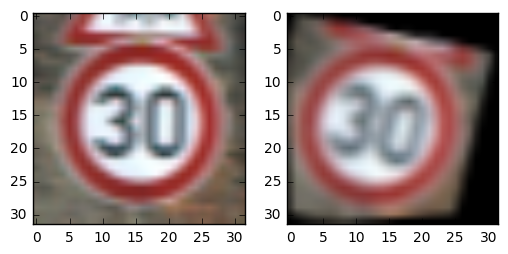

In [110]:
x_in = X_train[1000]
x_out = jitter_image(x_in)

plt.subplot(1,2,1)
plt.imshow(np.squeeze(x_in), cmap='gray');
plt.subplot(1,2,2)
plt.imshow(np.squeeze(x_out), cmap='gray');

In [111]:
X_train, y_train = extend_training_data(X_train, y_train)

(392090, 32, 32, 3)
(392090,)
(39209, 32, 32, 3)
(39209,)


### Dataset splitting

In [ ]:
### Dataset splitting
validation_size = 0.1
X_train_final, X_dev_final, y_train_final, y_dev_final = \
sklearn.model_selection.train_test_split(X_train_preprocessed, y_train_preprocessed, random_state=918273645)

# Plot a few images to see if they look good
plt.figure()
plt.title('Training set')
for i in range(4):
    plt.subplot(2, 2, i + 1);
    plt.imshow(np.squeeze(X_train_final[i, :, :, :]), cmap='gray');
    plt.axis('off');

plt.figure();
plt.title('Validation set')
for i in range(4):
    plt.subplot(2, 2, i + 1);
    plt.imshow(np.squeeze(X_dev_final[i, :, :, :]), cmap='gray');
    plt.axis('off');


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

We create training set using multiple of training_batch_size, so that
all the data is used during training. The validation set is 20% of that set.
We generate additional data because only 30000 images for training are not
sufficient. We obtained around 90% accuracy in test set
We generate 3 additional images to get a total of roughly
120000 training images, using translation, rotation and scaling.

---
## 2.1. Network architecture

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### 2.1.1 Helper functions

In [ ]:
### Helper functions
def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))    
    
def create_biases(shape):    
    return tf.Variable(tf.zeros(shape) + 0.05)

def flatten_layer(layer):
    # Shape is [batch_size, img_h, img_w, img_depth]    
    layer_shape = layer.get_shape()
    
    # Number of features per image
    num_features = layer_shape[1:4].num_elements()
    
    # Must reshape into [batch_size, n_features]. Since the batch_size is unknown
    # we type -1 so tf will figure it out itself
    return tf.reshape(layer, [-1, num_features])

### 2.1.2 Convolutional layer

This function creates a convolutional layer, taking as input a 4D tensor of shape [batch_size, width, height, depth]. The parameters are the filter size, number of filters, and options to include a Max Pooling layer and ReLU.

In [ ]:
def create_conv_layer(input_layer,          # 4D tensor
                      filter_size,          # scalar
                      n_filters,            # scalar
                      use_pooling=True,
                      use_relu=True):    # boolean
    # Review https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#conv2d
    # for conventions about input shapes

    # Create weights (4D tensor) and biases (1D vector)
    input_depth = int(input_layer.get_shape()[3])
    weight_shape = [filter_size, filter_size, input_depth, n_filters]
    bias_shape = [n_filters]
    
    weights = create_weights(weight_shape)
    biases = create_biases(bias_shape)
    
    # Convolution
    layer = tf.nn.conv2d(input=input_layer, 
                         filter=weights,
                         strides=[1,1,1,1], 
                         padding='SAME')
    # Add bias
    layer = tf.nn.bias_add(layer, biases)
    
    # Max pooling
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1,2,2,1],
                               strides=[1,2,2,1],
                               padding='SAME')
    
    # ReLU. Should be applied before pooling. However the result is the same and in this
    # case we perform fewer computations, since there are fewer pixels
    if use_relu:
        layer = tf.nn.relu(layer)
    
    return layer


### 2.1.3 Fully-connected layer
This function creates a fully connected layer, taking as input a 2D matrix of shape [batch_size, n_features] and having a number of outputs as a parameter. It also includes an optional boolean argument to include ReLU or not.

In [ ]:
def create_fc_layer(input_layer,       # 2D matrix [batch_size, n_inputs]
                    n_outputs,
                    use_relu=True):        # scalar

    n_inputs = int(input_layer.get_shape()[1])
    weights = create_weights([n_inputs, n_outputs])
    biases = create_biases([n_outputs])
    
    # XW + b
    layer = tf.matmul(input_layer, weights)
    layer = tf.nn.bias_add(layer, biases)
    
    # ReLU
    if use_relu:
        layer = tf.nn.relu(layer)
    
    return layer   

### 2.1.4 Network parameter design
In the following code cell, we define the sizes of the layers of the convolutional neural network.

In [ ]:
### Network parameters
# Input
img_size_w = X_train_final.shape[1]
img_size_h = X_train_final.shape[2]
img_size_d = X_train_final.shape[3]
img_size_total = img_size_w * img_size_h * img_size_d

# Conv layer 1
layer1_filter_size = 5
layer1_n_filters = 16

# Conv layer 2
layer2_filter_size = 5
layer2_n_filters = 32

# Fully Connected 1
fc1_n_neurons = 128

# Fully Connected 2
fc2_n_neurons = n_classes

### 2.1.5 Placeholder variables
This code cell contains placeholder variables, i.e. variables that we feed with data inside the TensorFlow session.

In [ ]:
### Placeholder variables
# Input: batch of images - 4D tensor [batch_size, img_h, img_w, img_d]
x = tf.placeholder(tf.float32, shape=[None, img_size_h, img_size_w, img_size_d])

# Output: true class - 2D matrix, one-hot encoded value [batch_size, n_classes]
y_true = tf.placeholder(tf.float32, shape=[None, n_classes])

# True class (not hot encoded) vector [batch_size]
y_true_class = tf.argmax(y_true, dimension=1)

print('x = ', x)
print('y_true = ', y_true)

### 2.1.6 Network implementation
After implementing some helper functions and designing the network, now we include code cells that actually implement each one of the layers of the convolutional neural network.

In [ ]:
### Network architecture
# First Layer: Conv + ReLU + Max pool
layer1 = create_conv_layer(input_layer=x,
                           filter_size=layer1_filter_size,
                           n_filters=layer1_n_filters,
                           use_pooling=True,
                           use_relu=True)
print("Layer 1 = ", layer1)


In [ ]:
# Second Layer: Conv + ReLU + Max pool
layer2 = create_conv_layer(input_layer=layer1,
                           filter_size=layer2_filter_size,
                           n_filters=layer2_n_filters,
                           use_pooling=True,
                           use_relu=True)
print("Layer 2 = ", layer2)

In [ ]:
# Third Layer: Fully Connected + ReLU
flattened_layer2 = flatten_layer(layer2)
print(flattened_layer2)
layer3 = create_fc_layer(input_layer=flattened_layer2,
                         n_outputs=fc1_n_neurons,
                         use_relu=True)
print("Layer 3 = ", layer3)

In [ ]:
# Fourth Layer: Fully Connected
# NOTE: ReLU is not used, since the output will go directly to the Softmax function
layer4 = create_fc_layer(input_layer=layer3,
                         n_outputs=fc2_n_neurons,
                         use_relu=False)
print("Layer 4 = ", layer4)

In [ ]:
# Softmax
y_predicted = tf.nn.softmax(layer4)
y_predicted_class = tf.argmax(y_predicted, dimension=1)
print(y_predicted)

In [ ]:
### Optimization
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer4,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

learning_rate = 0.0001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

### 2.1.7 Performance evaluation
Finally, we define the computations required in order to obtain the training, validation and test accuracy, with which we can evaluate the performance of the proposed network.

In [ ]:
### Performance evaluation
# Check if the predicted class is equal to the true class
is_correct_prediction = tf.equal(y_predicted_class, y_true_class)

# Compute the accuracy by averaging out the previous variable
accuracy = 100.0 * tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The architecture is shown in Figure 1.

![alt text](res/architecture2.png "Figure 1: Network Architecture")


It can be seen that it is a convolutional neural network, composed to:

1. First Layer: convolutional. Takes an input of 32x32x1 pixels and
convolves it with 16 5x5x1 filters. Maxpooling reduces the size 
of the output by a half, obtaining 16x16x16.

2. Second layer: convolutiona. Takes an input of 16x16x16 pixels, and convolves
with 32 5x5x1 filters. Again, maxpooling is used. The output is 8x8x32. 

3. Third layer: fully connected. We first flatten the previous input to a 2048
feature vector. The layer has 128 neurons.

4. Fourth layer: takes the previous 128-vector and outputs 43 neurons, the number
of classes.

5. Finally, the classifier applies the softmax function and outputs the class
with the largest probability. 

This model is simple yet powerful, greatly inspired by the cited paper.


---
## 2.2 Network training

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [ ]:
# Training paramters
n_epochs = 200
train_batch_size = 128
test_batch_size = 128

n_batches = int(np.floor(X_train_final.shape[0] / train_batch_size))

print ("Training the network for %d epochs." % n_epochs)
print ("The batch size is %d, and there are %d training examples, so we use %d batches per epoch" % (train_batch_size, X_train_final.shape[0], n_batches))

In [ ]:
# Helper function to get a batch from a dataset
def get_batch(x, y, batch_size, batch_idx):
    max_size = x.shape[0]
    start_idx = batch_idx * batch_size

    x_batch = x[start_idx : np.minimum(start_idx + batch_size, max_size), :, :, :]
    y_batch = y[start_idx : np.minimum(start_idx + batch_size, max_size), :]
    
    return (x_batch, y_batch)

In [ ]:
def get_test_accuracy(x_data, y_data, batch_size):
    n_batches = int(np.ceil(x_data.shape[0] / batch_size))
    accuracies = np.zeros([n_batches])

    for i in range(n_batches):
         # Get batch
        batch_x, batch_y = get_batch(x_data, y_data, batch_size, i)
        
        # Create feed dictionary
        feed_data = {x: batch_x, y_true: batch_y}

        # Feed it to the network and update the weights
        accuracies[i] = sess.run(accuracy, feed_dict=feed_data)
       
    return np.mean(accuracies)

In [ ]:
# Create TensorFlow session and initialize variables
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [ ]:
# Train network
training_accuracy = []
validation_accuracy = [0]

for i_epoch in range(n_epochs):
    
    # Loop through batches
    for i_batch in range(n_batches):
        # Get batch
        batch_x_train, batch_y_train = get_batch(X_train_final, y_train_final, train_batch_size, i_batch)
        
        # Create feed dictionary
        feed_data_train = {x: batch_x_train, y_true: batch_y_train}

        # Feed it to the network and update the weights
        sess.run(optimizer, feed_dict=feed_data_train)       

        # Compute the training and validation accuracy
        if (i_batch == n_batches - 1):
            training_accuracy.append(sess.run(accuracy, feed_data_train))
            print('Epoch %d - training acc: %.1f%%' % (i_epoch, training_accuracy[-1]))


In [ ]:
# Plot training and validation accuracy, and print the final value
iteration_vector = range(len(training_accuracy))

plt.subplot(1,2,1)
plt.plot(iteration_vector, np.array(training_accuracy));
plt.title('Training accuracy');
#print(training_accuracy)

print("Final training accuracy: %.1f%%" % (training_accuracy[-1]))

#plt.subplot(1,2,2)
#plt.plot(iteration_vector, validation_accuracy);
#plt.title('Validation accuracy');
#print("Final validation accuracy: %.1f%%" % (100.0 * validation_accuracy[-1]))
print('Validation accuracy: %.1f%%' % get_test_accuracy(X_dev_final, y_dev_final, test_batch_size))


### 2.3 Network evaluation on Test set

In [ ]:
print('Test accuracy: %.1f%%' % get_test_accuracy(X_test_preprocessed, y_test_preprocessed, test_batch_size))

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

The model was trained using:

* AdamOptimizer. After watching CS231n, we observe the GradientDescentOptimizer
is not the best one, and actually pretty slow. AdamOptimizer was then recommended.

* Learning rate = 0.0001, as suggested in the TensorFlow tutorial.

* Batch size: 128, in order to fit in GPU memory

No more hyperparameters were used.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

The approach to solving the traffic sign recognition problem was to use 
a convolutional neural network. These type of networks are well suited for
image processing problems (since convolutions are typical operations on them), 
and the number of required parameters is much smaller (since the weights are shared).

The main reference was the paper cited above, where they propose a 2 conv + 2 FC
network architecture. Many TensorFlow tutorials used this approach so it seemed
like a robust and well tested solution.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [ ]:
# Helper functions to process the input images
def load_img(img_path):
    img = cv2.imread(img_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def crop_img(img, crop_info):
    crop_x1 = crop_info[0]
    crop_y1 = crop_info[1]
    crop_x2 = crop_info[2]
    crop_y2 = crop_info[3]
    
    return img[crop_y1:crop_y2, crop_x1:crop_x2, :]
    
def resize_img(img, new_size):
    return cv2.resize(img, new_size)

In [ ]:
# Read CSV containing: image path, crop_x, crop_y, class
test_img_csv = 'test_img/test_img.csv'

n_tests = 5
X_test_own = np.zeros([n_tests, img_size_h, img_size_w, 3], dtype=np.float32)
y_test_own_labels = np.zeros([n_tests], dtype=int)

resize_size = (img_size_h, img_size_w)

with open(test_img_csv, 'r') as csvfile:
    i_img = 0
    reader = csv.reader(csvfile, delimiter=',')    
    for row in reader:
        # Read information from CSV file
        filename = row[0]
        crop_info = np.array(row[1:5], dtype=int)
        img_class = row[5]
        
        # Update test set
        img = load_img(filename)
        img = crop_img(img, crop_info)
        img = resize_img(img, resize_size)
        
        #img = X_test[500, :, :, :]
        
        X_test_own[i_img, :, :, :] = img
        y_test_own_labels[i_img] = labels_text.index(img_class);
        
        # Plot image
        plt.figure();
        plt.imshow(img);
        plt.title(img_class);

# Preprocessing
#X_test_own = X_train[0:5, :, :, :]
#y_test_own_labels = y_train[0:5]
#print (y_test_own_labels)

X_test_own = preprocess_set(X_test_own)
y_test_own = one_hot_encoding(y_test_own_labels, n_classes)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



## **Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

In [ ]:
# Prediction
y_pred_own_class = sess.run(y_predicted_class, feed_dict={x: X_test_own})

for i in y_pred_own_class.astype(int):
    print(labels_text[i])

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
top_k_classes = 5
y_pred_own_top_k_prob = tf.nn.top_k(y_predicted, top_k_classes);

y_pred_own_prob, y_pred_own_idx = sess.run(y_pred_own_top_k_prob, feed_dict={x: X_test_own})

for i in range(X_test_own.shape[0]):
    plt.figure()
    plt.imshow(np.squeeze(X_test_own[i, :, :, :]), cmap='gray')
    text = ''
    for j in range(top_k_classes):
        text += labels_text[y_pred_own_idx[i, j]] + ' - %.1f%%' % (100.0 * y_pred_own_prob[i,j]) + '\n'
    plt.xlabel(text)    

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.